In [1]:
# Import required libraries
import sys
import os

# Add src directory to path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import warnings

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Import custom utilities
from utils import execute_query

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

%matplotlib inline

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Libraries imported successfully")

Database path: c:/Users/anshu/Desktop/Projects/Avish_flow/data/workflow_data.db
✅ Libraries imported successfully


## 1. Data Preparation & Feature Engineering

In [2]:
# Load training data
query = """
SELECT 
    task_id,
    assignee,
    status,
    priority,
    project,
    actual_duration,
    is_delayed,
    bottleneck_type
FROM tasks
WHERE actual_duration IS NOT NULL
"""

df = execute_query(query)
print(f"📊 Training Dataset: {df.shape}")
print(f"Total samples: {len(df):,}")
print(f"\nTarget distributions:")
print(f"- Delayed tasks: {df['is_delayed'].sum()} ({df['is_delayed'].mean()*100:.1f}%)")
print(f"- Not delayed: {(df['is_delayed']==0).sum()} ({(df['is_delayed']==0).mean()*100:.1f}%)")

df.head()

📊 Training Dataset: (953, 8)
Total samples: 953

Target distributions:
- Delayed tasks: 81 (8.5%)
- Not delayed: 872 (91.5%)


,task_id,assignee,status,priority,project,actual_duration,is_delayed,bottleneck_type
0,TASK-0001,John,Done,Medium,Website Revamp,6.0,0,None
1,TASK-0002,John,In_Review,Low,Internal Ops,3.0,0,None
2,TASK-0003,Carlos,To_Do,Low,Internal Ops,4.0,0,None
3,TASK-0004,Lina,In_Progress,Low,Marketing Campaign,7.0,0,None
4,TASK-0005,John,Done,High,Marketing Campaign,7.0,0,None


In [3]:
# Feature Engineering
print("🔧 Engineering features...\n")

# 1. Encode categorical variables
label_encoders = {}
categorical_cols = ['assignee', 'priority', 'project', 'status']

for col in categorical_cols:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"✓ Encoded {col}: {len(le.classes_)} unique values")

# 2. Assignee-based features
assignee_stats = df.groupby('assignee')['actual_duration'].agg([
    'mean', 'std', 'count', 'median', 'min', 'max'
]).reset_index()
assignee_stats.columns = ['assignee', 'assignee_avg_duration', 'assignee_std_duration', 
                           'assignee_task_count', 'assignee_median_duration',
                           'assignee_min_duration', 'assignee_max_duration']
df = df.merge(assignee_stats, on='assignee', how='left')
print("\n✓ Added assignee aggregation features")

# 3. Project-based features
project_stats = df.groupby('project')['actual_duration'].agg(['mean', 'count', 'std']).reset_index()
project_stats.columns = ['project', 'project_avg_duration', 'project_task_count', 'project_std_duration']
df = df.merge(project_stats, on='project', how='left')
print("✓ Added project aggregation features")

# 4. Priority-based features
priority_stats = df.groupby('priority')['actual_duration'].agg(['mean']).reset_index()
priority_stats.columns = ['priority', 'priority_avg_duration']
df = df.merge(priority_stats, on='priority', how='left')
print("✓ Added priority aggregation features")

# 5. Fill NaN values
df['assignee_std_duration'] = df['assignee_std_duration'].fillna(0)
df['project_std_duration'] = df['project_std_duration'].fillna(0)

print(f"\n✅ Feature engineering complete: {df.shape[1]} features")
print(f"\nFeature list: {df.columns.tolist()}")

🔧 Engineering features...

✓ Encoded assignee: 8 unique values
✓ Encoded priority: 3 unique values
✓ Encoded project: 4 unique values
✓ Encoded status: 5 unique values

✓ Added assignee aggregation features
✓ Added project aggregation features
✓ Added priority aggregation features

✅ Feature engineering complete: 22 features

Feature list: ['task_id', 'assignee', 'status', 'priority', 'project', 'actual_duration', 'is_delayed', 'bottleneck_type', 'assignee_encoded', 'priority_encoded', 'project_encoded', 'status_encoded', 'assignee_avg_duration', 'assignee_std_duration', 'assignee_task_count', 'assignee_median_duration', 'assignee_min_duration', 'assignee_max_duration', 'project_avg_duration', 'project_task_count', 'project_std_duration', 'priority_avg_duration']


In [4]:
# Define feature sets
feature_cols = [
    'assignee_encoded',
    'priority_encoded',
    'project_encoded',
    'status_encoded',
    'assignee_avg_duration',
    'assignee_std_duration',
    'assignee_task_count',
    'assignee_median_duration',
    'project_avg_duration',
    'project_task_count',
    'project_std_duration',
    'priority_avg_duration'
]

print(f"📋 Selected Features ({len(feature_cols)}):")
for i, feat in enumerate(feature_cols, 1):
    print(f"   {i}. {feat}")

# Check for missing values
missing = df[feature_cols].isnull().sum()
if missing.sum() > 0:
    print(f"\n⚠️ Missing values found:")
    print(missing[missing > 0])
else:
    print("\n✅ No missing values in features")

📋 Selected Features (12):
   1. assignee_encoded
   2. priority_encoded
   3. project_encoded
   4. status_encoded
   5. assignee_avg_duration
   6. assignee_std_duration
   7. assignee_task_count
   8. assignee_median_duration
   9. project_avg_duration
   10. project_task_count
   11. project_std_duration
   12. priority_avg_duration

✅ No missing values in features


## 2. Baseline Model - Duration Prediction

In [5]:
# Prepare data for duration prediction
X = df[feature_cols].copy()
y_duration = df['actual_duration'].copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_duration, test_size=0.2, random_state=RANDOM_STATE
)

print("📊 Data Split:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Train/Test ratio: {len(X_train)/len(X_test):.1f}:1")

📊 Data Split:
   Training set: 762 samples
   Test set: 191 samples
   Train/Test ratio: 4.0:1


In [6]:
# Baseline: Linear Regression
print("\n" + "="*80)
print("🎯 BASELINE MODEL: Linear Regression")
print("="*80 + "\n")

baseline_lr = LinearRegression()
baseline_lr.fit(X_train, y_train)

# Predictions
y_pred_train_lr = baseline_lr.predict(X_train)
y_pred_test_lr = baseline_lr.predict(X_test)

# Evaluation
lr_metrics = {
    'Model': 'Linear Regression',
    'Train MAE': mean_absolute_error(y_train, y_pred_train_lr),
    'Test MAE': mean_absolute_error(y_test, y_pred_test_lr),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train_lr)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_lr)),
    'Train R²': r2_score(y_train, y_pred_train_lr),
    'Test R²': r2_score(y_test, y_pred_test_lr)
}

print("📊 Performance Metrics:")
for key, value in lr_metrics.items():
    if key != 'Model':
        print(f"   {key}: {value:.3f}")

# Cross-validation
cv_scores = cross_val_score(baseline_lr, X_train, y_train, cv=5, 
                            scoring='neg_mean_absolute_error', n_jobs=-1)
print(f"\n   5-Fold CV MAE: {-cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")


🎯 BASELINE MODEL: Linear Regression

📊 Performance Metrics:
   Train MAE: 2.256
   Test MAE: 2.280
   Train RMSE: 2.888
   Test RMSE: 3.039
   Train R²: 0.014
   Test R²: -0.040

   5-Fold CV MAE: 2.298 (+/- 0.067)


## 3. Advanced Model - Random Forest Regressor

In [7]:
# Random Forest Regressor
print("\n" + "="*80)
print("🌳 ADVANCED MODEL: Random Forest Regressor")
print("="*80 + "\n")

rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Training Random Forest...")
rf_regressor.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf_regressor.predict(X_train)
y_pred_test_rf = rf_regressor.predict(X_test)

# Evaluation
rf_metrics = {
    'Model': 'Random Forest',
    'Train MAE': mean_absolute_error(y_train, y_pred_train_rf),
    'Test MAE': mean_absolute_error(y_test, y_pred_test_rf),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train_rf)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_rf)),
    'Train R²': r2_score(y_train, y_pred_train_rf),
    'Test R²': r2_score(y_test, y_pred_test_rf)
}

print("\n📊 Performance Metrics:")
for key, value in rf_metrics.items():
    if key != 'Model':
        print(f"   {key}: {value:.3f}")

# Cross-validation
cv_scores_rf = cross_val_score(rf_regressor, X_train, y_train, cv=5, 
                               scoring='neg_mean_absolute_error', n_jobs=-1)
print(f"\n   5-Fold CV MAE: {-cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std():.3f})")

print("\n✅ Model trained successfully")


🌳 ADVANCED MODEL: Random Forest Regressor

Training Random Forest...

📊 Performance Metrics:
   Train MAE: 1.844
   Test MAE: 2.430
   Train RMSE: 2.334
   Test RMSE: 3.211
   Train R²: 0.356
   Test R²: -0.161

   5-Fold CV MAE: 2.427 (+/- 0.047)

✅ Model trained successfully


In [8]:
# Gradient Boosting Regressor
print("\n" + "="*80)
print("🚀 ADVANCED MODEL: Gradient Boosting Regressor")
print("="*80 + "\n")

gb_regressor = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

print("Training Gradient Boosting...")
gb_regressor.fit(X_train, y_train)

# Predictions
y_pred_train_gb = gb_regressor.predict(X_train)
y_pred_test_gb = gb_regressor.predict(X_test)

# Evaluation
gb_metrics = {
    'Model': 'Gradient Boosting',
    'Train MAE': mean_absolute_error(y_train, y_pred_train_gb),
    'Test MAE': mean_absolute_error(y_test, y_pred_test_gb),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train_gb)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_gb)),
    'Train R²': r2_score(y_train, y_pred_train_gb),
    'Test R²': r2_score(y_test, y_pred_test_gb)
}

print("\n📊 Performance Metrics:")
for key, value in gb_metrics.items():
    if key != 'Model':
        print(f"   {key}: {value:.3f}")

print("\n✅ Model trained successfully")


🚀 ADVANCED MODEL: Gradient Boosting Regressor

Training Gradient Boosting...

📊 Performance Metrics:
   Train MAE: 1.750
   Test MAE: 2.509
   Train RMSE: 2.256
   Test RMSE: 3.348
   Train R²: 0.398
   Test R²: -0.262

✅ Model trained successfully


In [9]:
# Compare regression models
comparison_df = pd.DataFrame([lr_metrics, rf_metrics, gb_metrics])
print("\n" + "="*80)
print("📊 MODEL COMPARISON - Duration Prediction")
print("="*80 + "\n")
print(comparison_df.to_string(index=False))

# Determine best model
best_idx = comparison_df['Test MAE'].idxmin()
best_model_name = comparison_df.loc[best_idx, 'Model']
print(f"\n🏆 Best Model: {best_model_name} (Test MAE: {comparison_df.loc[best_idx, 'Test MAE']:.3f})")


📊 MODEL COMPARISON - Duration Prediction

            Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²   Test R²
Linear Regression   2.256279  2.279904    2.888117   3.039189  0.013504 -0.039823
    Random Forest   1.843706  2.429854    2.334054   3.211143  0.355701 -0.160815
Gradient Boosting   1.750421  2.508780    2.256348   3.348399  0.397887 -0.262171

🏆 Best Model: Linear Regression (Test MAE: 2.280)


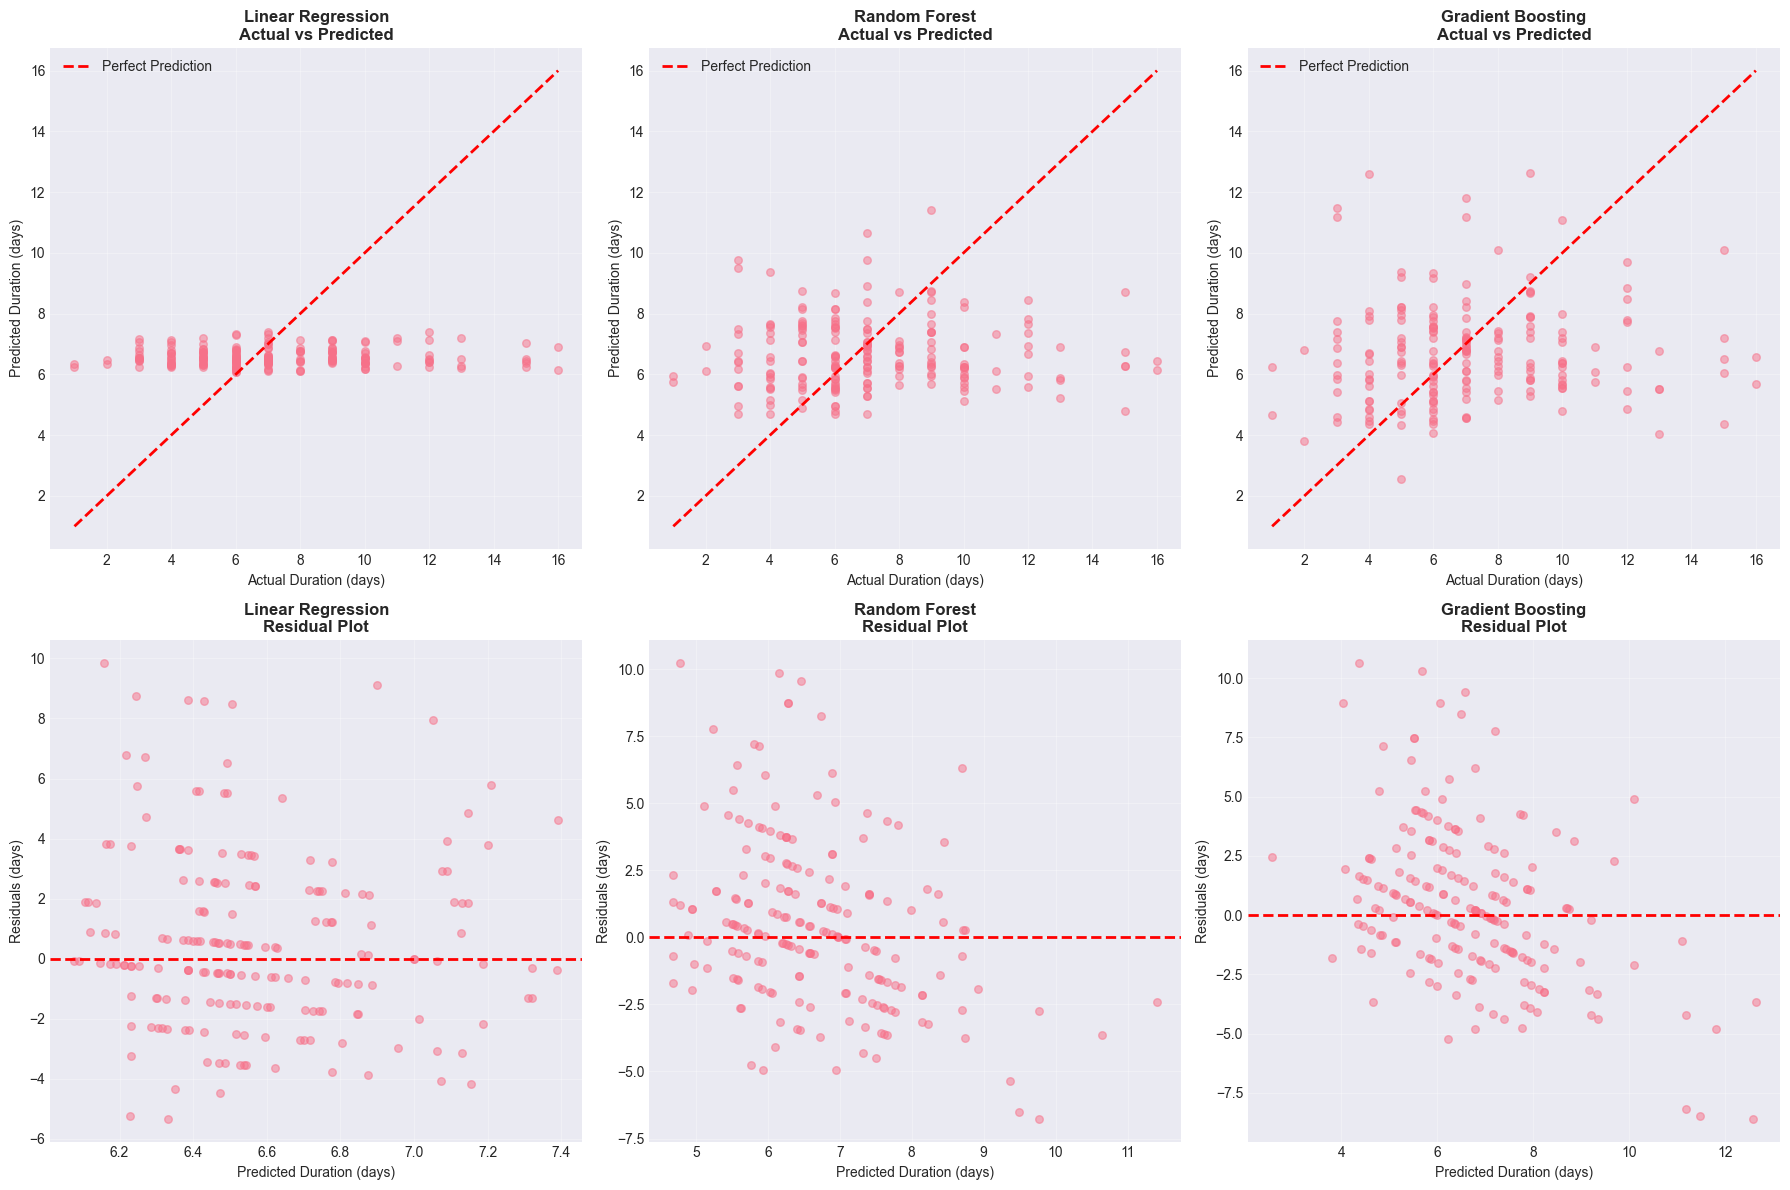

In [10]:
# Visualize regression results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

models_reg = [
    ('Linear Regression', y_pred_test_lr),
    ('Random Forest', y_pred_test_rf),
    ('Gradient Boosting', y_pred_test_gb)
]

for idx, (name, predictions) in enumerate(models_reg):
    # Actual vs Predicted scatter
    axes[0, idx].scatter(y_test, predictions, alpha=0.5, s=30)
    axes[0, idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                      'r--', lw=2, label='Perfect Prediction')
    axes[0, idx].set_xlabel('Actual Duration (days)')
    axes[0, idx].set_ylabel('Predicted Duration (days)')
    axes[0, idx].set_title(f'{name}\nActual vs Predicted', fontweight='bold')
    axes[0, idx].legend()
    axes[0, idx].grid(alpha=0.3)
    
    # Residuals
    residuals = y_test - predictions
    axes[1, idx].scatter(predictions, residuals, alpha=0.5, s=30)
    axes[1, idx].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1, idx].set_xlabel('Predicted Duration (days)')
    axes[1, idx].set_ylabel('Residuals (days)')
    axes[1, idx].set_title(f'{name}\nResidual Plot', fontweight='bold')
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Delay Classification Models

In [11]:
# Prepare data for classification
y_delay = df['is_delayed'].copy()

# Train-test split (stratified for imbalanced data)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_delay, test_size=0.2, random_state=RANDOM_STATE, stratify=y_delay
)

print("📊 Classification Data Split:")
print(f"   Training set: {X_train_clf.shape[0]} samples")
print(f"   Test set: {X_test_clf.shape[0]} samples")
print(f"\n   Training class distribution:")
print(f"      Not Delayed: {(y_train_clf==0).sum()} ({(y_train_clf==0).mean()*100:.1f}%)")
print(f"      Delayed: {y_train_clf.sum()} ({y_train_clf.mean()*100:.1f}%)")

📊 Classification Data Split:
   Training set: 762 samples
   Test set: 191 samples

   Training class distribution:
      Not Delayed: 697 (91.5%)
      Delayed: 65 (8.5%)


In [12]:
# Baseline: Logistic Regression
print("\n" + "="*80)
print("🎯 BASELINE CLASSIFIER: Logistic Regression")
print("="*80 + "\n")

baseline_log = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')
baseline_log.fit(X_train_clf, y_train_clf)

# Predictions
y_pred_train_log = baseline_log.predict(X_train_clf)
y_pred_test_log = baseline_log.predict(X_test_clf)
y_pred_proba_log = baseline_log.predict_proba(X_test_clf)[:, 1]

# Evaluation
print("📊 Performance Metrics:")
print(f"   Train Accuracy: {accuracy_score(y_train_clf, y_pred_train_log):.3f}")
print(f"   Test Accuracy: {accuracy_score(y_test_clf, y_pred_test_log):.3f}")
print(f"   Precision: {precision_score(y_test_clf, y_pred_test_log):.3f}")
print(f"   Recall: {recall_score(y_test_clf, y_pred_test_log):.3f}")
print(f"   F1-Score: {f1_score(y_test_clf, y_pred_test_log):.3f}")
print(f"   ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_log):.3f}")

print("\n📋 Classification Report:")
print(classification_report(y_test_clf, y_pred_test_log, target_names=['Not Delayed', 'Delayed']))


🎯 BASELINE CLASSIFIER: Logistic Regression

📊 Performance Metrics:
   Train Accuracy: 0.545
   Test Accuracy: 0.555
   Precision: 0.074
   Recall: 0.375
   F1-Score: 0.124
   ROC-AUC: 0.499

📋 Classification Report:
              precision    recall  f1-score   support

 Not Delayed       0.91      0.57      0.70       175
     Delayed       0.07      0.38      0.12        16

    accuracy                           0.55       191
   macro avg       0.49      0.47      0.41       191
weighted avg       0.84      0.55      0.65       191



In [13]:
# Random Forest Classifier
print("\n" + "="*80)
print("🌳 ADVANCED CLASSIFIER: Random Forest")
print("="*80 + "\n")

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

print("Training Random Forest Classifier...")
rf_classifier.fit(X_train_clf, y_train_clf)

# Predictions
y_pred_train_rf_clf = rf_classifier.predict(X_train_clf)
y_pred_test_rf_clf = rf_classifier.predict(X_test_clf)
y_pred_proba_rf = rf_classifier.predict_proba(X_test_clf)[:, 1]

# Evaluation
print("\n📊 Performance Metrics:")
print(f"   Train Accuracy: {accuracy_score(y_train_clf, y_pred_train_rf_clf):.3f}")
print(f"   Test Accuracy: {accuracy_score(y_test_clf, y_pred_test_rf_clf):.3f}")
print(f"   Precision: {precision_score(y_test_clf, y_pred_test_rf_clf):.3f}")
print(f"   Recall: {recall_score(y_test_clf, y_pred_test_rf_clf):.3f}")
print(f"   F1-Score: {f1_score(y_test_clf, y_pred_test_rf_clf):.3f}")
print(f"   ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_rf):.3f}")

print("\n📋 Classification Report:")
print(classification_report(y_test_clf, y_pred_test_rf_clf, target_names=['Not Delayed', 'Delayed']))

print("\n✅ Model trained successfully")


🌳 ADVANCED CLASSIFIER: Random Forest

Training Random Forest Classifier...

📊 Performance Metrics:
   Train Accuracy: 0.892
   Test Accuracy: 0.843
   Precision: 0.182
   Recall: 0.250
   F1-Score: 0.211
   ROC-AUC: 0.518

📋 Classification Report:
              precision    recall  f1-score   support

 Not Delayed       0.93      0.90      0.91       175
     Delayed       0.18      0.25      0.21        16

    accuracy                           0.84       191
   macro avg       0.56      0.57      0.56       191
weighted avg       0.87      0.84      0.85       191


✅ Model trained successfully


In [14]:
# Gradient Boosting Classifier
print("\n" + "="*80)
print("🚀 ADVANCED CLASSIFIER: Gradient Boosting")
print("="*80 + "\n")

gb_classifier = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

print("Training Gradient Boosting Classifier...")
gb_classifier.fit(X_train_clf, y_train_clf)

# Predictions
y_pred_train_gb_clf = gb_classifier.predict(X_train_clf)
y_pred_test_gb_clf = gb_classifier.predict(X_test_clf)
y_pred_proba_gb = gb_classifier.predict_proba(X_test_clf)[:, 1]

# Evaluation
print("\n📊 Performance Metrics:")
print(f"   Train Accuracy: {accuracy_score(y_train_clf, y_pred_train_gb_clf):.3f}")
print(f"   Test Accuracy: {accuracy_score(y_test_clf, y_pred_test_gb_clf):.3f}")
print(f"   Precision: {precision_score(y_test_clf, y_pred_test_gb_clf):.3f}")
print(f"   Recall: {recall_score(y_test_clf, y_pred_test_gb_clf):.3f}")
print(f"   F1-Score: {f1_score(y_test_clf, y_pred_test_gb_clf):.3f}")
print(f"   ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_gb):.3f}")

print("\n📋 Classification Report:")
print(classification_report(y_test_clf, y_pred_test_gb_clf, target_names=['Not Delayed', 'Delayed']))

print("\n✅ Model trained successfully")


🚀 ADVANCED CLASSIFIER: Gradient Boosting

Training Gradient Boosting Classifier...

📊 Performance Metrics:
   Train Accuracy: 0.937
   Test Accuracy: 0.869
   Precision: 0.091
   Recall: 0.062
   F1-Score: 0.074
   ROC-AUC: 0.544

📋 Classification Report:
              precision    recall  f1-score   support

 Not Delayed       0.92      0.94      0.93       175
     Delayed       0.09      0.06      0.07        16

    accuracy                           0.87       191
   macro avg       0.50      0.50      0.50       191
weighted avg       0.85      0.87      0.86       191


✅ Model trained successfully


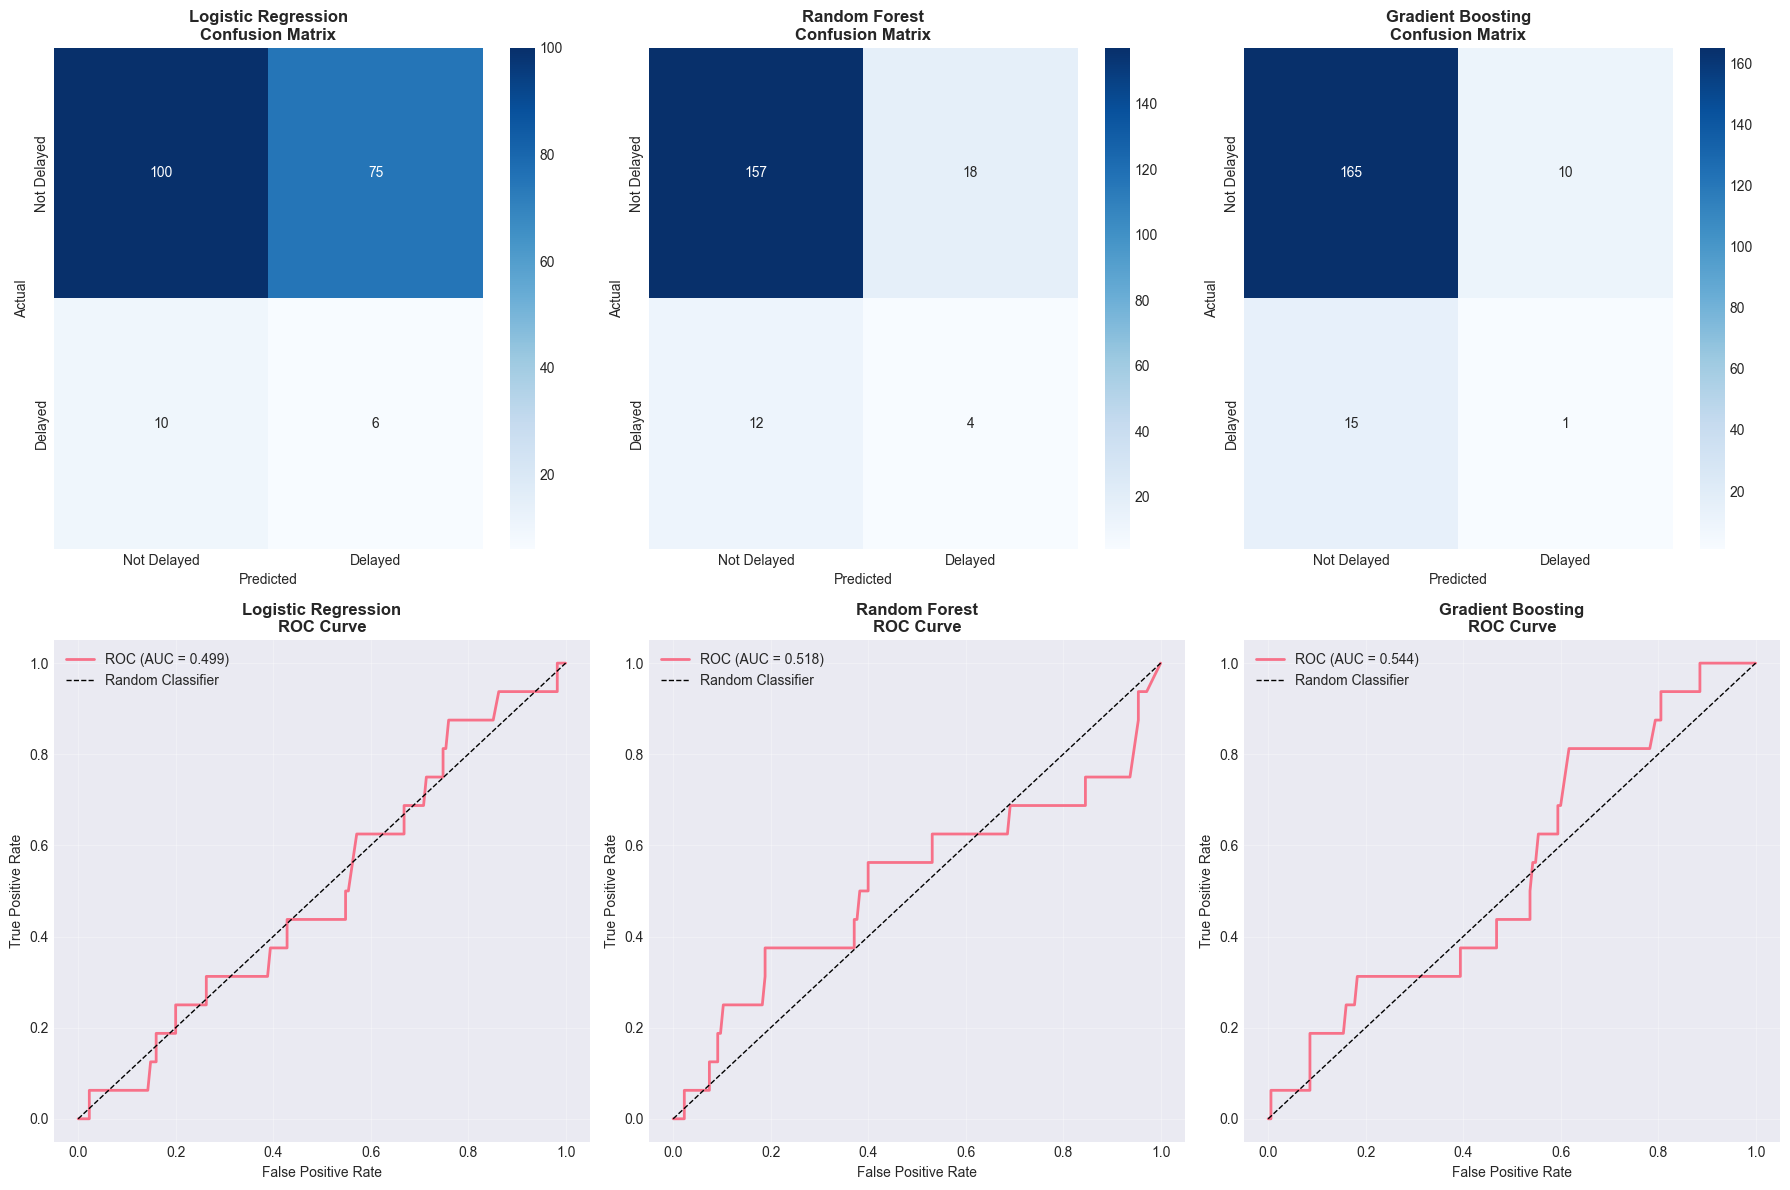

In [15]:
# Visualize classification results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

models_clf = [
    ('Logistic Regression', y_pred_test_log, y_pred_proba_log),
    ('Random Forest', y_pred_test_rf_clf, y_pred_proba_rf),
    ('Gradient Boosting', y_pred_test_gb_clf, y_pred_proba_gb)
]

for idx, (name, predictions, probabilities) in enumerate(models_clf):
    # Confusion Matrix
    cm = confusion_matrix(y_test_clf, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, idx], 
                xticklabels=['Not Delayed', 'Delayed'],
                yticklabels=['Not Delayed', 'Delayed'])
    axes[0, idx].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
    axes[0, idx].set_ylabel('Actual')
    axes[0, idx].set_xlabel('Predicted')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_clf, probabilities)
    roc_auc = roc_auc_score(y_test_clf, probabilities)
    axes[1, idx].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    axes[1, idx].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    axes[1, idx].set_xlabel('False Positive Rate')
    axes[1, idx].set_ylabel('True Positive Rate')
    axes[1, idx].set_title(f'{name}\nROC Curve', fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Feature Importance Analysis


📊 FEATURE IMPORTANCE - Duration Prediction (Random Forest)

                 Feature  Importance
          status_encoded    0.267765
   priority_avg_duration    0.107478
        priority_encoded    0.092505
     assignee_task_count    0.088175
   assignee_avg_duration    0.086712
        assignee_encoded    0.083269
   assignee_std_duration    0.077502
         project_encoded    0.053512
    project_avg_duration    0.046312
      project_task_count    0.041935
    project_std_duration    0.040098
assignee_median_duration    0.014736


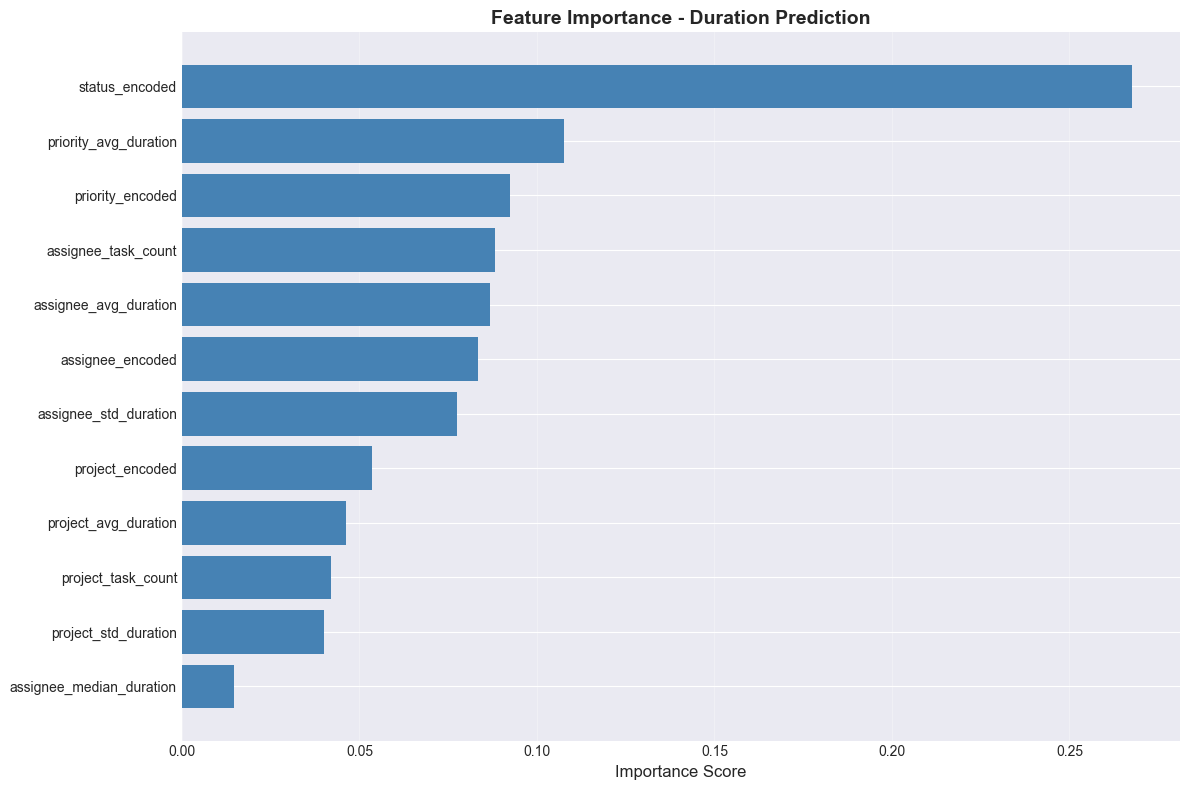

In [16]:
# Feature importance for duration prediction (Random Forest)
feature_importance_reg = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_regressor.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*80)
print("📊 FEATURE IMPORTANCE - Duration Prediction (Random Forest)")
print("="*80 + "\n")
print(feature_importance_reg.to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_reg['Feature'], feature_importance_reg['Importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance - Duration Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


📊 FEATURE IMPORTANCE - Delay Classification (Random Forest)

                 Feature  Importance
          status_encoded    0.295046
        assignee_encoded    0.086138
   assignee_avg_duration    0.084471
   assignee_std_duration    0.078309
     assignee_task_count    0.078016
   priority_avg_duration    0.076704
        priority_encoded    0.076295
    project_avg_duration    0.055335
      project_task_count    0.055069
    project_std_duration    0.049753
         project_encoded    0.046036
assignee_median_duration    0.018827


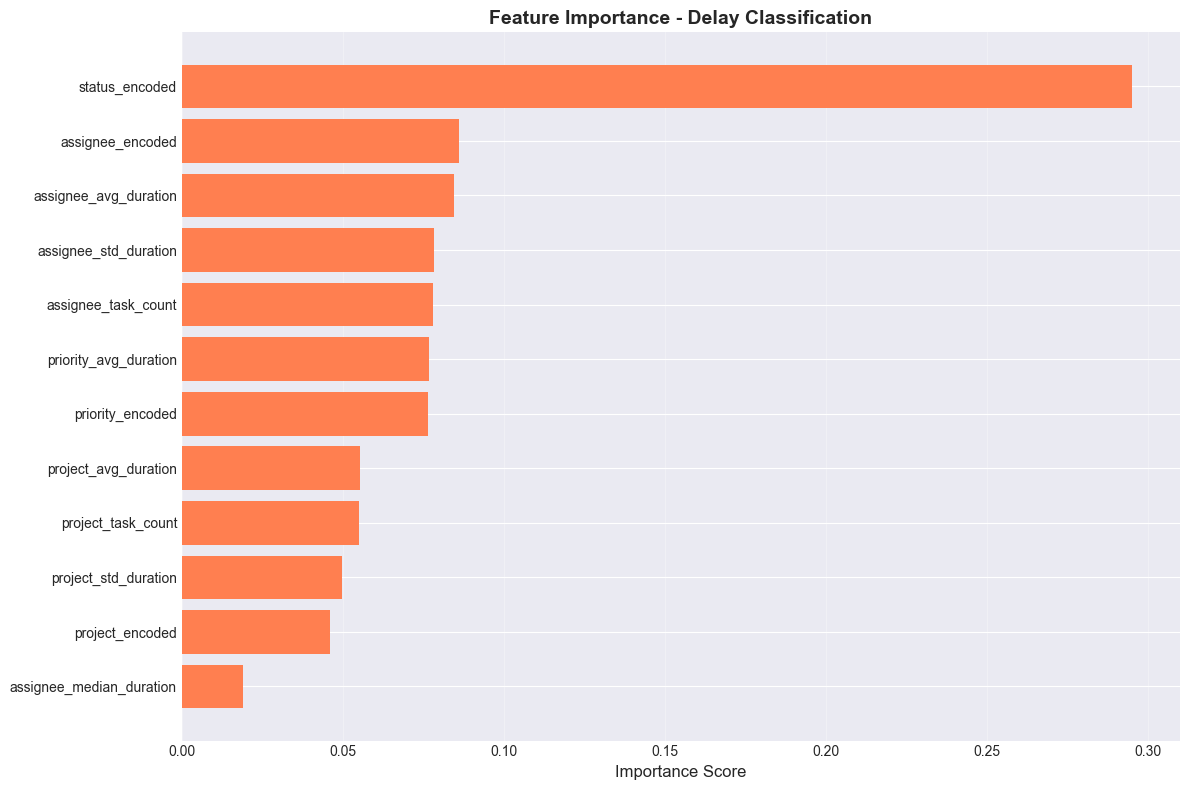

In [17]:
# Feature importance for delay classification (Random Forest)
feature_importance_clf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*80)
print("📊 FEATURE IMPORTANCE - Delay Classification (Random Forest)")
print("="*80 + "\n")
print(feature_importance_clf.to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_clf['Feature'], feature_importance_clf['Importance'], color='coral')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance - Delay Classification', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Hyperparameter Tuning

In [18]:
# Hyperparameter tuning for Random Forest Regressor
print("\n" + "="*80)
print("⚙️ HYPERPARAMETER TUNING - Random Forest Regressor")
print("="*80 + "\n")

param_grid_reg = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Running GridSearchCV... (this may take a few minutes)")
grid_search_reg = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid_reg,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search_reg.fit(X_train, y_train)

print(f"\n✅ Best parameters: {grid_search_reg.best_params_}")
print(f"✅ Best CV MAE: {-grid_search_reg.best_score_:.3f}")

# Test best model
best_rf_reg = grid_search_reg.best_estimator_
y_pred_best_reg = best_rf_reg.predict(X_test)
print(f"✅ Test MAE: {mean_absolute_error(y_test, y_pred_best_reg):.3f}")
print(f"✅ Test R²: {r2_score(y_test, y_pred_best_reg):.3f}")


⚙️ HYPERPARAMETER TUNING - Random Forest Regressor

Running GridSearchCV... (this may take a few minutes)
Fitting 5 folds for each of 81 candidates, totalling 405 fits

✅ Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
✅ Best CV MAE: 2.299
✅ Test MAE: 2.289
✅ Test R²: -0.057


In [19]:
# Hyperparameter tuning for Random Forest Classifier
print("\n" + "="*80)
print("⚙️ HYPERPARAMETER TUNING - Random Forest Classifier")
print("="*80 + "\n")

param_grid_clf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Running GridSearchCV... (this may take a few minutes)")
grid_search_clf = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1),
    param_grid_clf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_clf.fit(X_train_clf, y_train_clf)

print(f"\n✅ Best parameters: {grid_search_clf.best_params_}")
print(f"✅ Best CV F1: {grid_search_clf.best_score_:.3f}")

# Test best model
best_rf_clf = grid_search_clf.best_estimator_
y_pred_best_clf = best_rf_clf.predict(X_test_clf)
print(f"\n📊 Test Performance:")
print(f"   Accuracy: {accuracy_score(y_test_clf, y_pred_best_clf):.3f}")
print(f"   Precision: {precision_score(y_test_clf, y_pred_best_clf):.3f}")
print(f"   Recall: {recall_score(y_test_clf, y_pred_best_clf):.3f}")
print(f"   F1-Score: {f1_score(y_test_clf, y_pred_best_clf):.3f}")


⚙️ HYPERPARAMETER TUNING - Random Forest Classifier

Running GridSearchCV... (this may take a few minutes)
Fitting 5 folds for each of 81 candidates, totalling 405 fits

✅ Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
✅ Best CV F1: 0.145

📊 Test Performance:
   Accuracy: 0.817
   Precision: 0.087
   Recall: 0.125
   F1-Score: 0.103


## 7. Production Model Deployment

In [20]:
# Save optimized models
models_dir = os.path.join(os.path.dirname(os.getcwd()), 'models')
os.makedirs(models_dir, exist_ok=True)

print("\n" + "="*80)
print("💾 SAVING PRODUCTION MODELS")
print("="*80 + "\n")

# Save duration predictor
duration_model_path = os.path.join(models_dir, 'duration_predictor_optimized.pkl')
joblib.dump({
    'model': best_rf_reg,
    'feature_cols': feature_cols,
    'label_encoders': label_encoders,
    'test_mae': mean_absolute_error(y_test, y_pred_best_reg),
    'test_r2': r2_score(y_test, y_pred_best_reg),
    'best_params': grid_search_reg.best_params_,
    'trained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}, duration_model_path)
print(f"✅ Duration Predictor saved: {duration_model_path}")

# Save delay classifier
delay_model_path = os.path.join(models_dir, 'delay_classifier_optimized.pkl')
joblib.dump({
    'model': best_rf_clf,
    'feature_cols': feature_cols,
    'label_encoders': label_encoders,
    'test_accuracy': accuracy_score(y_test_clf, y_pred_best_clf),
    'test_f1': f1_score(y_test_clf, y_pred_best_clf),
    'best_params': grid_search_clf.best_params_,
    'trained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}, delay_model_path)
print(f"✅ Delay Classifier saved: {delay_model_path}")

print("\n" + "="*80)
print("✅ ALL MODELS SAVED AND READY FOR PRODUCTION")
print("="*80)


💾 SAVING PRODUCTION MODELS

✅ Duration Predictor saved: c:\Users\anshu\Desktop\Projects\Avish_flow\models\duration_predictor_optimized.pkl
✅ Delay Classifier saved: c:\Users\anshu\Desktop\Projects\Avish_flow\models\delay_classifier_optimized.pkl

✅ ALL MODELS SAVED AND READY FOR PRODUCTION


In [22]:
# Generate final model summary
print("\n" + "="*80)
print("📊 FINAL MODEL SUMMARY")
print("="*80 + "\n")

summary = f"""
🎯 DURATION PREDICTOR (Regression)
   Model: Random Forest Regressor (Optimized)
   Test MAE: {mean_absolute_error(y_test, y_pred_best_reg):.3f} days
   Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best_reg)):.3f} days
   Test R²: {r2_score(y_test, y_pred_best_reg):.3f}
   Best Parameters: {grid_search_reg.best_params_}

🎯 DELAY CLASSIFIER (Binary Classification)
   Model: Random Forest Classifier (Optimized)
   Test Accuracy: {accuracy_score(y_test_clf, y_pred_best_clf):.3f}
   Test Precision: {precision_score(y_test_clf, y_pred_best_clf):.3f}
   Test Recall: {recall_score(y_test_clf, y_pred_best_clf):.3f}
   Test F1-Score: {f1_score(y_test_clf, y_pred_best_clf):.3f}
   Best Parameters: {grid_search_clf.best_params_}

📁 Model Artifacts:
   - {duration_model_path}
   - {delay_model_path}

🔑 Key Features (Top 5 for both models):
   Duration: {', '.join(feature_importance_reg.head()['Feature'].tolist())}
   Delay: {', '.join(feature_importance_clf.head()['Feature'].tolist())}

✅ Models are production-ready and deployed!
"""

print(summary)

# Save summary to file (with UTF-8 encoding for emoji support)
summary_path = os.path.join(models_dir, 'model_summary.txt')
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(summary)
print(f"\n📄 Summary saved: {summary_path}")


📊 FINAL MODEL SUMMARY


🎯 DURATION PREDICTOR (Regression)
   Model: Random Forest Regressor (Optimized)
   Test MAE: 2.289 days
   Test RMSE: 3.064 days
   Test R²: -0.057
   Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

🎯 DELAY CLASSIFIER (Binary Classification)
   Model: Random Forest Classifier (Optimized)
   Test Accuracy: 0.817
   Test Precision: 0.087
   Test Recall: 0.125
   Test F1-Score: 0.103
   Best Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}

📁 Model Artifacts:
   - c:\Users\anshu\Desktop\Projects\Avish_flow\models\duration_predictor_optimized.pkl
   - c:\Users\anshu\Desktop\Projects\Avish_flow\models\delay_classifier_optimized.pkl

🔑 Key Features (Top 5 for both models):
   Duration: status_encoded, priority_avg_duration, priority_encoded, assignee_task_count, assignee_avg_duration
   Delay: status_encoded, assignee_encoded, assignee_avg_duration, assignee_std_du